Source: https://www.machinelearningplus.com/time-series/time-series-analysis-python/

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [27]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from datetime import datetime
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.tools as tls
import plotly.offline as pyo
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pmdarima import auto_arima
from fbprophet import Prophet
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import GridSearchCV
from datetime import date, timedelta
from sklearn.neural_network import MLPRegressor
import pickle

pyo.init_notebook_mode(connected=True)

# Obiettivo

L'obiettivo di questo progetto è quello di rispondere alla seguente domanda: "Quando le terapie intensive, italiane, lombarde e francesi, potranno ritenersi libere da casi COVID19?

Realizzeremo quindi diversi modelli di predizione addestrati ad-hoc. Proveremo poi ad utilizzare il modello addestrato sui dati italiani per realizzare una predizione sulla situazione della terapia intensiva francese.

# Time Series Analysis

In questa sezione analizzeremo i dati relativi alle terapie intensive.

Prenderemo in considerazione solamente l'andamento italiano in quanto, per questo tipo di analisi e dati, risulta sufficiente a capire se vi è un qualche tipo di stagionalità o stazionarietà.

Vediamo come il picco sia stato raggiunto intorno ai primi di Aprile e da più di un mese esse si stanno liberando.

Vedremo poi le varie tecniche per la loro analisi.

In [29]:
#Plotto in grafico dell'intero dataset
fig = px.line(series, x="date", y="terapia_intensiva", title='Andamento terapia intensiva')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

Con questo grafico vediamo la distribuzione delle terapie intensive a livello mensile. Come si nota dal grafico, i mesi più intensi sono stati quelli di Marzo e Aprile

In [30]:
tmp = series.copy()
#Creo una nuova colonna con indicato il mese, preso dalla colonna "date"
tmp['month'] = [d.strftime('%b') for d in tmp.date]
#Plotto il grafico box
fig = px.box(tmp, x="month", y="terapia_intensiva")
fig.show()

### Seasonal Decompose

In questa sezione analizzeremo la stagionalità e i trend della terapia intensiva.

In [31]:
#Funzione che, dato un DecomposeResult, estrae le 4 proprietà e le plotta in 4 differenti grafici
def decompose_plot(result, title):
    observed = result.observed
    seasonal = result.seasonal
    trend = result.trend
    resid = result.resid
    fig = make_subplots(rows=4, cols=1,
                        subplot_titles=("Observed", "Trend", "Seasonal", "Resid"),
                        shared_xaxes=True)
    fig.add_trace(go.Scatter(x=series["date"], y=observed, mode='lines', name='observed'), row=1, col=1)
    fig.add_trace(go.Scatter(x=series["date"], y=trend, mode='lines', name='trend'), row=2, col=1)
    fig.add_trace(go.Scatter(x=series["date"], y=seasonal, mode='lines', name='seasonal'), row=3, col=1)
    fig.add_trace(go.Scatter(x=series["date"], y=resid, mode='markers', name='resid'), row=4, col=1)
    fig.update_layout(height=600, width=900, title_text=title)
    fig.show()

Per prima proviamo a decomporre la time series con la modalità moltiplicativa. Possiamo vedere dal grafico del trend come non sia presente una stagionalità marcata.

In [32]:
result_mul = seasonal_decompose(series["terapia_intensiva"], model='multiplicative', period=7)
decompose_plot(result_mul, "Multiplicative Decompose")

Ora invece proviamo a decomporre la time series con la modalità additiva. Possiamo vedere dal grafico del trend come non sia presente una stagionalità marcata.

In [33]:
result_add = seasonal_decompose(series["terapia_intensiva"], model='additive', period=7)
decompose_plot(result_add, "Additive Decompose")

### Stationarity

In questa sezione cercheremo la stazionarità dei dati, per capire se sono dipendenti dal tempo.

#### Stationarity Test (ADF)

Con il test Augmented Dickey-Fuller, verificheremo a livello statistico se la time series è stazionaria o meno.

source: https://machinelearningmastery.com/time-series-data-stationary-python/

In [34]:
#Augmented Dickey-Fuller test
result = adfuller(series.terapia_intensiva.values, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critial Values:')
for key, value in result[4].items():
    print(f'   {key}, {value}')

ADF Statistic: -3.725262
p-value: 0.003772
Critial Values:
   1%, -3.5117123057187376
   5%, -2.8970475206326833
   10%, -2.5857126912469153


Dato che p-value è risultato inferiore a 0.05, possiamo confermare che la time series è stazionaria.

### Autocorrelation and Partial Autocorrelation

Le funzioni di autocorrelazione e parziale autocorrelazione permettono di capire se, in presenza di picchi ripetuti, è presente una forte stagionalità.

Nel nostro caso non sono presenti evedenti ripetizioni di picchi, dunque non siamo in presenza di una stagionalità evidente.

/home/simone/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



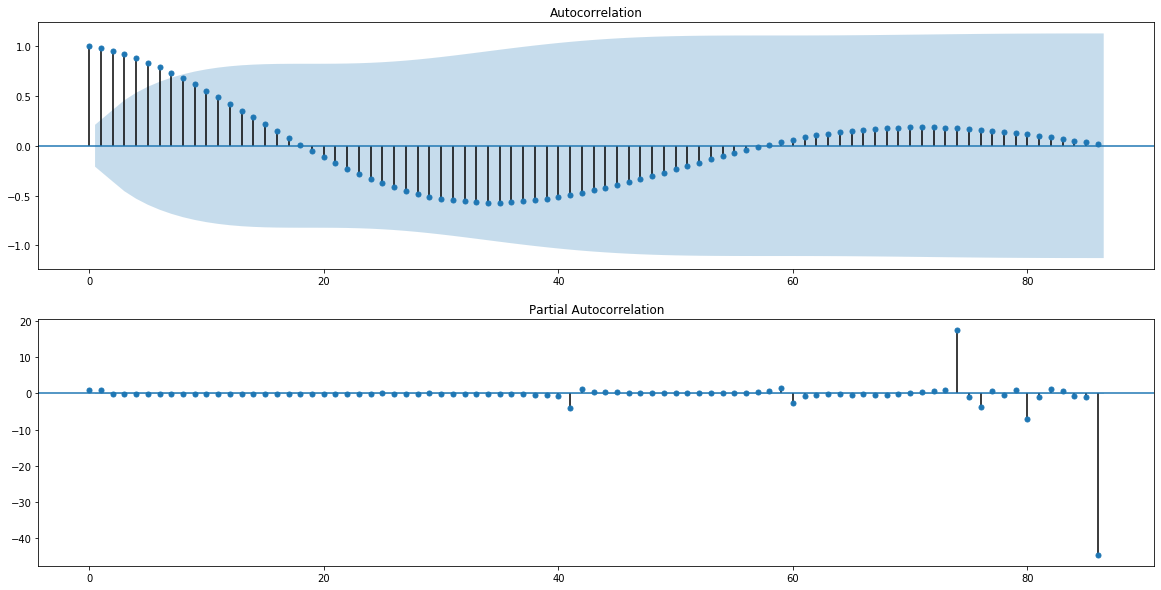

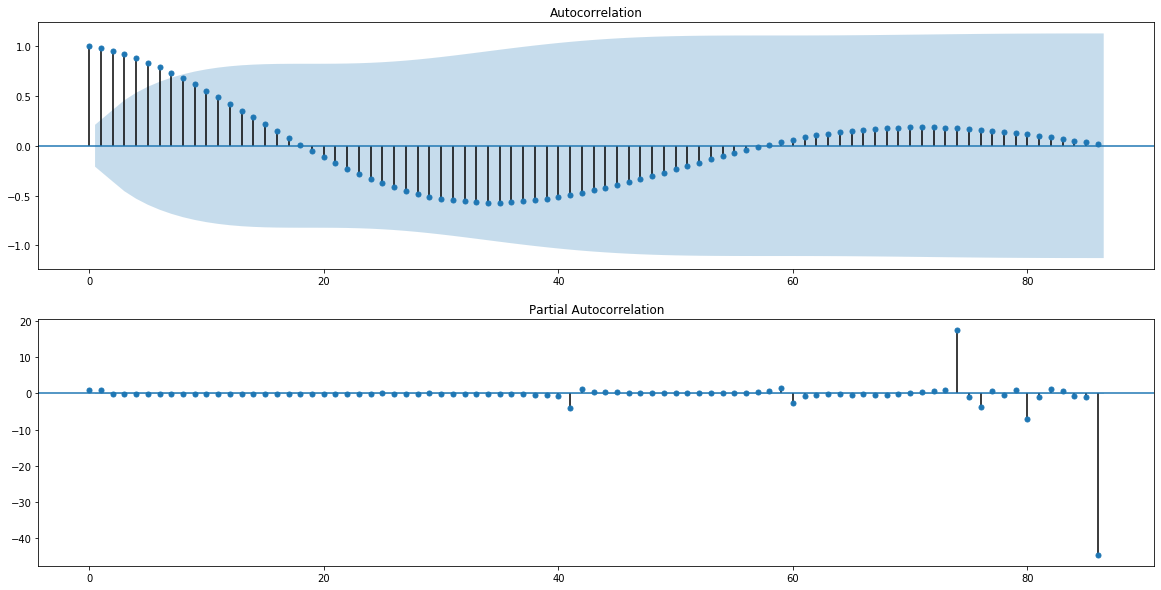

In [35]:
#Lunghezza della time series da plottare
l = len(series.terapia_intensiva)-1

fig,ax = plt.subplots(2,1,figsize=(20,10))
plot_acf(series.terapia_intensiva, lags=l, ax=ax[0])
plot_pacf(series.terapia_intensiva, lags=l, ax=ax[1])

### Conclusione sull'analisi delle time series

Con l'analisi effettuata sui dati della time series riguardante le terapie intensive, abbiamo potuto osservare come non vi sia presente la caratteristica relativa alla stagionalità.

Ciò potrebbe essere determinato anche dalla scarsa quantità dei dati e quindi la presenza di una possibile stagionalità annuale potrà essere verificata solo nei prossimi anni.

Tuttavia con il test di Augmented Dickey-Fuller, una verifica a livello statistico, abbiamo confermato la stazionarietà dei dati.

Abbiamo potuto anche osservare come, dopo il picco di Aprile, vi sia una discesa lineare della curva. Possiamo dunque andare a prediligere dei modelli che si adattino meglio a questo tipo di curve.

# Analisi Nazionale Italia

In questa sezione andremo ad analizzare il dataset italiano.

Nello specifico vedremo l'analisi delle time series, poi procederemo con l'esecuzione di modelli statistici per la predizione delle terapie intensive, infine vedremo dei modelli di machine learning per la predizione delle terapie intensive, degli attualmente positivi e degli attualmente ospedalizzati.

In [28]:
#Importo i dati dell'anadamento della terapia intensiva a livello nazionale
series = pd.read_csv('Datasets/ProtezioneCivile/ts_nazioni_terapia.csv', index_col = 0)
series = series.T
series.reset_index(inplace=True)
series.rename(columns = {'index':'date', 'terapia_intensiva':'terapia_intensiva'}, inplace = True)
series["date"] = pd.to_datetime(series["date"])
series.head()

,date,terapia_intensiva
0,2020-02-24,26
1,2020-02-25,35
2,2020-02-26,36
3,2020-02-27,56
4,2020-02-28,64


## Time Series Predictions

In questa senzione inizieremo a predirre l'andamento delle terapie intensive utilizzando diversi modelli statistici.

In [36]:
#Numero di giorni da prevedere
prev_d = 60

### Autoregression

L'autoregressione è un modello per le time series che, utilizzando le osservazioni dei giorni precedenti come input ad una equazione di regressione lineare, predice i valori successivi. Questo metodo è adatto a time series senza trend e stagionalità.

In [37]:
series_autoreg = series.copy()
series_autoreg.set_index('date', inplace=True)

#Estraggo la colonna delle terapia intensive come array
terapia = np.array(series_autoreg.terapia_intensiva)

model = AutoReg(terapia, lags=[1, 2, 3, 4, 11, 12], trend='t', seasonal=True, period=1)
model_fit = model.fit()
pred = model_fit.predict(len(terapia), len(terapia)+prev_d)

In [38]:
#Funzione che ritorna una data aggiungendo n all'ultimo giorno della time series
def addDate(n):
    last_date = series_autoreg.index[-1]
    end_date = last_date + datetime.timedelta(days=n)
    return str(end_date.date())

Possiamo vedere come la predizione dell'andamento delle terapie intensive è in linea con la struttura della curva negli ultimi giorni, prevede dunque un azzeramento intorno al 12 di Giugno.

In [39]:
#Ottengo un array con le date da prevedere
dates = [] 
for i in range(len(pred)):
    dates.append(addDate(i+1))

predict = pd.DataFrame(dates, columns =['date'])
predict['terapia_intensiva'] = pred.tolist()
predict.set_index('date', inplace=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=series_autoreg.index, y=series_autoreg["terapia_intensiva"], mode='lines', name='terapia_intensiva'))
fig.add_trace(go.Scatter(x=predict.index, y=predict["terapia_intensiva"], mode='lines', name='Predict'))
fig.add_shape(type="line",x0=series_autoreg.index[0],y0=0,x1=predict.index[-1],y1=0)
fig.show()

### Moving Average

La media mobile cerca di predirre il prossimo valore comportandosi come una funzione lineare dell'errore residuo dato da una media dei precedenti valori. Questo metodo è adatto a time series senza trend e stagionalità.

In [40]:
series_ma = series.copy()
series_ma.set_index('date', inplace=True)

model = ARMA(series_ma["terapia_intensiva"], order=(1, 1, 1), freq='D')
model_fit = model.fit(disp=False)
forecast = model_fit.predict(len(series_ma), len(series_ma))

In [41]:
forecast = forecast.to_frame(name="terapia_intensiva")
forecast.reset_index(inplace=True)
forecast.rename(columns = {'index':'date', 'terapia_intensiva':'terapia_intensiva'}, inplace = True)
forecast.set_index('date', inplace=True)

In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=series_autoreg.index, y=series_autoreg["terapia_intensiva"], mode='lines', name='terapia_intensiva'))
fig.add_trace(go.Scatter(x=forecast.index, y=forecast["terapia_intensiva"], mode='markers', name='Predict'))
fig.show()

### Arima 

Arima combina i modelli visti precedentemente. Vi è una fase di pre processamento della time series per renderla stazionaria.

In [43]:
scaler = MinMaxScaler(feature_range=(0, 1))

def scale(series):
    df_scaled = pd.DataFrame(scaler.fit_transform(series), columns=series.columns)
    df_scaled["date"] = series.index
    df_scaled.set_index("date", inplace=True)
    return df_scaled

In [44]:
series_arima = series.copy()
series_arima.set_index('date', inplace=True)
series_arima = scale(series_arima)

Andiamo ora ad usare auto_arima per ricercare le configurazioni migliori da usare.

In [45]:
stepwise_fit = auto_arima(series_arima['terapia_intensiva'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',
                          suppress_warnings = True,
                          stepwise = True)
stepwise_fit.summary() 

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=-444.164, BIC=-432.643, Time=2.094 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=-324.681, BIC=-320.073, Time=0.118 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=-425.173, BIC=-415.957, Time=2.875 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=-381.368, BIC=-372.152, Time=4.203 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=-325.412, BIC=-323.108, Time=0.063 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=-424.242, BIC=-415.026, Time=0.218 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=-443.131, BIC=-429.306, Time=1.584 seconds
Fit ARIMA(1,1,1)x(0,1,2,12) [intercept=True]; AIC=-447.156, BIC=-433.332, Time=7.541 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 2, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(1,1,1)x(1,1,0,12) [intercept=True]; AIC=-43

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   87
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                 229.578
Date:                                 Fri, 22 May 2020   AIC                           -447.156
Time:                                         11:07:03   BIC                           -433.332
Sample:                                              0   HQIC                          -441.642
                                                  - 87                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.000     -0.379      0.705      -0.001       0.000
ar.L1          0.9595      0.067     14.293      0.000       0.828       1.091
ma.L1         -0.4285      0.180     -2.375      0.018      -0.782      -0.075
ma.S.L12      -0.8423      5.823     -0.145      0.885     -12.255      10.571
ma.S.L24      -0.1433      1.025     -0.140      0.889      -2.152       1.866
sigma2      8.917e-05      0.001      0.170      0.865      -0.001       0.001
===================================================================================
Ljung-Box (Q):                       47.90   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.18   Prob(JB):                         0.64
Heteroskedasticity (H):               1.03   Skew:                            -0.05
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
train = series_arima.iloc[:int(len(series)*0.70)] 
test = series_arima.iloc[int(len(series)*0.70):]

Andiamo quindi ad addestrare SARIMAX con le configurazioni trovate precedentemente e usando il 70% dei dati disponibili.

In [47]:
model = SARIMAX(train['terapia_intensiva'], order = (1, 1, 1), seasonal_order =(0, 1, 1, 12)) 

result = model.fit() 
result.summary() 

/home/simone/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/simone/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/simone/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  terapia_intensiva   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 145.356
Date:                            Fri, 22 May 2020   AIC                           -282.712
Time:                                    11:07:13   BIC                           -275.312
Sample:                                02-24-2020   HQIC                          -279.927
                                     - 04-23-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9704      0.113      8.588      0.000       0.749       1.192
ma.L1         -0.3188      0.275     -1.161      0.246      -0.857       0.219
ma.S.L12      -0.9361      2.275     -0.412      0.681      -5.395       3.523
sigma2      8.468e-05      0.000      0.444      0.657      -0.000       0.000
===================================================================================
Ljung-Box (Q):                       48.00   Jarque-Bera (JB):                 1.17
Prob(Q):                              0.18   Prob(JB):                         0.56
Heteroskedasticity (H):               0.80   Skew:                            -0.34
Prob(H) (two-sided):                  0.66   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Andiamo ora a effettuare la validazione sui dati di test (circa il 30%). Vediamo come la predizione del modello segua l'andamento effettivo dei dati reali.

In [48]:
start = len(train) 
end = len(train) + len(test) - 1

predictions = result.predict(start, end, typ = 'levels').rename("Predictions") 

predictions = predictions.to_frame(name="terapia_intensiva")
predictions.reset_index(inplace=True)
predictions.rename(columns = {'index':'date', 'terapia_intensiva':'terapia_intensiva'}, inplace = True)
predictions.set_index('date', inplace=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index, y=test["terapia_intensiva"], mode='lines', name='terapia_intensiva'))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions["terapia_intensiva"], mode='lines', name='Prediction'))
fig.show()

Vista la limitata quantità di dati disponibili, abbiamo deciso di utilizzare l'intera time series per l'addestramento.

In [49]:
model = SARIMAX(series_arima['terapia_intensiva'], order = (1, 1, 1), seasonal_order =(0, 1, 1, 12), freq="D")
result = model.fit()

/home/simone/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/simone/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Ora andremo a predirre l'andamento della terapia intensiva nel futuro.

In [50]:
forecast = result.predict(start = len(series), end = (len(series)-1) + prev_d, typ = 'levels').rename('Forecast')

forecast = forecast.to_frame(name="terapia_intensiva")
forecast.reset_index(inplace=True)
forecast.rename(columns = {'index':'date', 'terapia_intensiva':'terapia_intensiva'}, inplace = True)
forecast.set_index('date', inplace=True)

In [51]:
def reverse_scale(df_scaled):
    df = pd.DataFrame(scaler.inverse_transform(df_scaled), columns=df_scaled.columns)
    df["date"] = df_scaled.index
    df.set_index("date", inplace=True)
    return df


forecast = reverse_scale(forecast)
series_arima = reverse_scale(series_arima)

Vediamo come Arima dia l'azzeramento delle terapie intensive intorno al 18 di Giugno.

In [52]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=series_arima.index, y=series_arima["terapia_intensiva"], mode='lines', name='terapia_intensiva'))
fig.add_trace(go.Scatter(x=forecast.index, y=forecast["terapia_intensiva"], mode='lines', name='Prediction'))
fig.add_shape(type="line",x0=series_arima.index[0],y0=0,x1=forecast.index[-1],y1=0)
fig.show()

In [53]:
#Salvo il modello addestrato Arima
pkl_filename = "fitted_model/arima_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(result, file)

### Prophet Train-Test

Prophet è un modello di tipo additivo che lavora meglio con time series che hanno una forte stagionalità e diversi "stagioni" di dati.

Addestreremo il modello con circa il 90% dei dati a disposizione per validare il modello con il restante 10%.

In [59]:
series_prophet_tt = series.copy()
#Imposto i nomi delle colonne con "ds" e "y" come richiesto da Prophet
series_prophet_tt.columns = ['ds','y']

In [60]:
train = series_prophet_tt.iloc[:int(len(series)*0.90)] 
test = series_prophet_tt.iloc[int(len(series)*0.90):]

In [61]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train["ds"], y=train["y"], mode='lines', name='train'))
fig.add_trace(go.Scatter(x=test["ds"], y=test["y"], mode='lines', name='test'))
fig.show()

In [62]:
model = Prophet(changepoint_prior_scale=0.1)
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [63]:
#Prendo solo le colonne "ds" (le date) e "yhat" (la previsione)
test_pred = model.predict(test)[["ds", "yhat"]]

Vediamo come i dati predetti dal modello si discostino notevolmente da quelli effettivi. Ciò è dato dal fatto che la timeseries su cui addestriamo il modello non presenta stagionalità ne un quantitativo sufficiente di dati.

In [64]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train["ds"], y=train["y"], mode='lines', name='train'))
fig.add_trace(go.Scatter(x=test["ds"], y=test["y"], mode='lines', name='test'))
fig.add_trace(go.Scatter(x=test_pred["ds"], y=test_pred["yhat"], mode='lines', name='pred_test'))
fig.show()

In [65]:
future = model.make_future_dataframe(periods=60)
#future = future.truncate(before=len(series_prophet))
forecast = model.predict(future)

result = forecast[["ds", "yhat"]]

In [66]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=result["ds"], y=result["yhat"], mode='lines', name='Prediction'))
fig.add_trace(go.Scatter(x=series_prophet_tt["ds"], y=series_prophet_tt["y"], mode='lines', name='terapia_intensiva'))
fig.add_shape(type="line",x0=min(series_prophet_tt.ds),y0=0,x1=max(result.ds),y1=0)
fig.show()

### Prophet

Prophet è un modello di tipo additivo che lavora meglio con time series che hanno una forte stagionalità e diversi "stagioni" di dati.

In [54]:
series_prophet = series.copy()
#Imposto i nomi delle colonne con "ds" e "y" come richiesto da Prophet
series_prophet.columns = ['ds','y']

Il modello viene addestrato su tutto il dataset disponibile e viene fatta una previsione futura di 60 giorni.

In [55]:
model = Prophet(changepoint_prior_scale=0.1)
model.fit(series_prophet)
future = model.make_future_dataframe(periods=prev_d)
forecast = model.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [56]:
#Prendo solo le colonne "ds" (le date) e "yhat" (la previsione)
result = forecast[["ds", "yhat"]]

Vediamo come il grafico indichi che al primo di giugno le terapie intensive siano vuote. Ciò pare irrealistico in quanto esse diminuiscono all'incirca di 30 valori al giorno.

In [57]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=result["ds"], y=result["yhat"], mode='lines', name='Prediction'))
fig.add_trace(go.Scatter(x=series_prophet["ds"], y=series_prophet["y"], mode='lines', name='terapia_intensiva'))
fig.add_shape(type="line",x0=min(series_prophet.ds),y0=0,x1=max(result.ds),y1=0)
fig.show()

I seguenti grafici mostrano il trend e la stagionalità settimanale della timeseries.

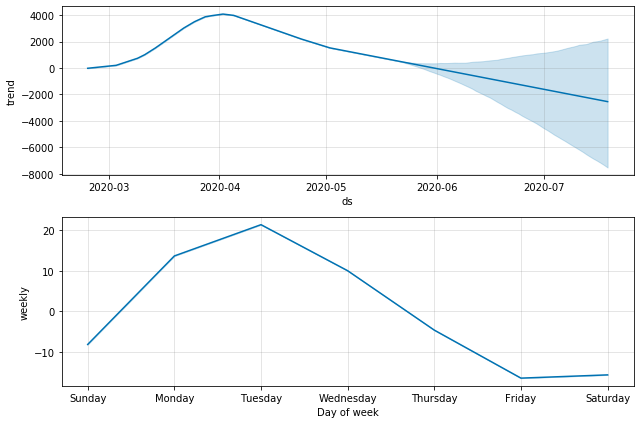

In [58]:
#fig1 = model.plot(forecast, figsize = (16, 9))
fig2 = model.plot_components(forecast)

## Previsioni con Machine Learning

### MLP Regressor

Il Multi-layer perceptron regressor è una rete neurale che viene addestrata iterativamente. In ogni fase vengono calcolate le derivate parziali relative alla funzione di costo (loss function) rispetto ai parametri del modello, in modo da aggiornare quest'ultimi.

Con MLP Regressor cercheremo di predirre l'andamento delle terapie intensive, degli attualmente positivi e degli ospedalizzati a livello italiano.

Per prima cosa vedremo l'andamento delle terapie intensive.

In [67]:
#Carico la timeseries relativa alle terapie intensive nazionali
series = pd.read_csv('Datasets/ProtezioneCivile/ts_nazioni_terapia.csv', index_col = 0)
series = series.T
series.head()
data = series.terapia_intensiva
x_1=np.arange(len(series.terapia_intensiva)).reshape(-1, 1)
y_1=series.terapia_intensiva.values

I blocchi di codice successivi sono stati utilizzati per ricercare i migliori parametri e addestrare il modello. Abbiamo provveduto a salvare il modello addestrato con pickle, così da non dover riaddestrare il modello.

In [68]:
#Imposto le combinazioni di parametri su cui fare il tuning
#parameters = {'hidden_layer_sizes':np.arange(500,1500,200),'alpha':[0.00001,0.00005,0.0001,0.0005], 'momentum':[0.85,0.9,0.95]}
#imposto il modello con i parametri che rimarranno invariati
#model = MLPRegressor(solver="lbfgs",max_iter=50000)
#istanzio il GridSearchCV per la ricerca della combinazione di parametri migliore
#gridCV = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_squared_error')
#gridCV.fit(x_1,y_1)
#stampo i parametri scelti da gridsearchcv
#print(gridCV.best_params_)

In [69]:
# save the model to disk
#filename = 'fitted_model/model_terapia_intensiva.sav'
#pickle.dump(gridCV, open(filename, 'wb'))

In [70]:
# load the model from disk
filename = 'fitted_model/model_terapia_intensiva.sav'
loaded_model = pickle.load(open(filename, 'rb'))

/home/simone/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.neural_network.multilayer_perceptron module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neural_network. Anything that cannot be imported from sklearn.neural_network is now part of the private API.

/home/simone/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning:

Trying to unpickle estimator MLPRegressor from version 0.21.3 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.

/home/simone/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.

Andiamo ora a predirre 30 giorni nel futuro. Vediamo come dopo 30 giorni non sia ancora stato raggiunto il valore 0.

In [71]:
#creo le x del test, aggiungendo 30 valori rispetto al train
test = np.arange(len(data)+30).reshape(-1, 1)
#effettuo la predizione su di essi
pred = loaded_model.predict(test)
prediction = pred.round().astype(int)
#recupero il primo index dai dati originali (che è una data), 
#gli aggiungo uno o più giorni con il ciclo sulla len di prediction, 
#ottenendo la lista delle date fino a 30 giorni dopo
week = [pd.to_datetime(data.index[0]) + timedelta(days=i) for i in range(len(prediction))]
#converto week a datetimeindex
dt_idx = pd.DatetimeIndex(week)
#creo una series con i valori in prediction e i nuovi index
predicted_count = pd.Series(prediction, dt_idx)

#aggiunge dei convertitori custom di pandas
register_matplotlib_converters()


#plotto
x_pred = predicted_count.index
y_pred = predicted_count.values
x_val = pd.DatetimeIndex(series.index)
y_val = series.terapia_intensiva

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_pred, y=y_pred, mode='lines', name='Previsione'))
fig.add_trace(go.Scatter(x=x_val, y=y_val, mode='lines', name='Andamento Terapia Intensiva'))
fig.show()

Con MLP Regressor cercheremo ora di predirre l'andamento degli attualmente positivi a livello italiano.

In [72]:
#Carico la timeseries relativa agli attualmente positivi nazionali
timeseriesPCNazionaleDataset = pd.read_csv("Datasets/ProtezioneCivile/dpc-covid19-ita-andamento-nazionale_clean.csv")
series = timeseriesPCNazionaleDataset[["data", "totale_positivi","totale_ospedalizzati"]].copy()
series.set_index("data", inplace = True)
series.head()
data = series.totale_positivi
x_1=np.arange(len(series.totale_positivi)).reshape(-1, 1)
y_1=series.totale_positivi.values

I blocchi di codice successivi sono stati utilizzati per ricercare i migliori parametri e addestrare il modello. Abbiamo provveduto a salvare il modello addestrato con pickle, così da non dover riaddestrare il modello.

In [73]:
#Imposto le combinazioni di parametri su cui fare il tuning
#parameters = {'hidden_layer_sizes':np.arange(500,1500,200),'alpha':[0.00001,0.00005,0.0001,0.0005], 'momentum':[0.85,0.9,0.95]}
#imposto il modello con i parametri che rimarranno invariati
#model = MLPRegressor(solver="lbfgs",max_iter=50000)
#istanzio il GridSearchCV per la ricerca della combinazione di parametri migliore
#gridCV = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_squared_error')
#gridCV.fit(x_1,y_1)
#stampo i parametri scelti da gridsearchcv
#print(gridCV.best_params_)

In [74]:
# save the model to disk
#filename = 'fitted_model/model_attualmente_positivi.sav'
#pickle.dump(gridCV, open(filename, 'wb'))

In [75]:
# load the model from disk
filename = 'fitted_model/model_attualmente_positivi.sav'
loaded_model = pickle.load(open(filename, 'rb'))

/home/simone/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning:

Trying to unpickle estimator MLPRegressor from version 0.21.3 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.

/home/simone/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning:

Trying to unpickle estimator GridSearchCV from version 0.21.3 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.



Andiamo ora a predirre 30 giorni nel futuro. Vediamo come intorno al 17 di Giugno venga raggiunto il valore 0 per gli attualmente positivi. Ciò è in contraddizione con il modello precedente e probabilmente irrealistico. Consideriamo comunque che il modello è stato addestrato con pochi dati e relativi al 17 di Maggio, andrebbe riaddestrato nelle settimane a seguire per verificare se vi è una variazione nella discesa della curva.

In [76]:
#creo le x del test, aggiungendo 30 valori rispetto al train
test = np.arange(len(data)+30).reshape(-1, 1)
#effettuo la predizione su di essi
pred = loaded_model.predict(test)
prediction = pred.round().astype(int)
#recupero il primo index dai dati originali (che è una data), 
#gli aggiungo uno o più giorni con il ciclo sulla len di prediction, 
#ottenendo la lista delle date fino a 30 giorni dopo
week = [pd.to_datetime(data.index[0]) + timedelta(days=i) for i in range(len(prediction))]
#converto week a datetimeindex
dt_idx = pd.DatetimeIndex(week)
#creo una series con i valori in prediction e i nuovi index
predicted_count = pd.Series(prediction, dt_idx)

#aggiunge dei convertitori custom di pandas
register_matplotlib_converters()


#plotto


x_pred = predicted_count.index
y_pred_attualmente_positivi = predicted_count.values
x_val = pd.DatetimeIndex(series.index)
y_val = series.totale_positivi

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_pred, y=y_pred_attualmente_positivi, mode='lines', name='Previsione'))
fig.add_trace(go.Scatter(x=x_val, y=y_val, mode='lines', name='Andamento Attualmente Positivi'))
fig.show()

Ricerchiamo una correlazione tra i dati presenti nel dataset.

In [77]:
df = timeseriesPCNazionaleDataset[["ricoverati_con_sintomi","terapia_intensiva","totale_ospedalizzati","totale_positivi"]]

fig = px.imshow(df.corr(), x=df.columns, y=df.columns)
fig.show()

Abbiamo deciso di predirre l'andamento degli ospedalizzati partendo dai positivi. Dunque, per poter predire il futuro servirà che forniamo in ingresso i valori attualmente positivi predetti precedentemente.

In [78]:
new_x = series.totale_positivi.values.reshape(-1,1)
new_x_test = y_pred_attualmente_positivi.reshape(-1,1)
new_y = series.totale_ospedalizzati.values

In [79]:
#Imposto le combinazioni di parametri su cui fare il tuning
#parameters = {'hidden_layer_sizes':np.arange(500,1500,200),'alpha':[0.00001,0.00005,0.0001,0.0005], 'momentum':[0.85,0.9,0.95]}
#imposto il modello con i parametri che rimarranno invariati
#model = MLPRegressor(solver="lbfgs",max_iter=50000)
#istanzio il GridSearchCV per la ricerca della combinazione di parametri migliore
#gridCV = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_squared_error')
#gridCV.fit(new_x,new_y)
#stampo i parametri scelti da gridsearchcv
#print(gridCV.best_params_)

In [80]:
# save the model to disk
#filename = 'fitted_model/model_positivi_to_ospedalizzati.sav'
#pickle.dump(gridCV, open(filename, 'wb'))

In [81]:
# load the model from disk
filename = 'fitted_model/model_positivi_to_ospedalizzati.sav'
loaded_model = pickle.load(open(filename, 'rb'))

/home/simone/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning:

Trying to unpickle estimator MLPRegressor from version 0.21.3 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.

/home/simone/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning:

Trying to unpickle estimator GridSearchCV from version 0.21.3 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.



Come vediamo dal grafico la previsione del modello si discosta dai dati reali.

In [82]:
#effettuo la predizione su di essi
pred = loaded_model.predict(new_x_test)
prediction = pred.round().astype(int)
#recupero il primo index dai dati originali (che è una data), 
#gli aggiungo uno o più giorni con il ciclo sulla len di prediction, 
#ottenendo la lista delle date fino a 30 giorni dopo
week = [pd.to_datetime(data.index[0]) + timedelta(days=i) for i in range(len(prediction))]
#converto week a datetimeindex
dt_idx = pd.DatetimeIndex(week)
#creo una series con i valori in prediction e i nuovi index
predicted_count = pd.Series(prediction, dt_idx)

#aggiunge dei convertitori custom di pandas
register_matplotlib_converters()


#plotto
x_pred = predicted_count.index
y_pred = predicted_count.values
x_val = pd.DatetimeIndex(series.index)
y_val = series.totale_ospedalizzati

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_pred, y=y_pred, mode='lines', name='Previsione'))
fig.add_trace(go.Scatter(x=x_val, y=y_val, mode='lines', name='Andamento Ospedalizzati'))
fig.show()

# Analisi Regionale Lombardia

In questa sezione andremo ad analizzare il dataset regionale, nello specifico lombardo.

Vedremo l'andamento della terapia intensiva lombarda, poi procederemo con l'esecuzione di modelli statistici per la predizione delle terapie intensive, infine vedremo dei modelli di machine learning per la predizione delle terapie intensive, degli attualmente positivi e dei ricoverati con sintomi

In [83]:
#Importo i dati dell'anadamento della terapia intensiva a livello regionale
series = pd.read_csv('Datasets/ProtezioneCivile/ts_regioni_terapia.csv', index_col = 0)
series = series.T
series.reset_index(inplace=True)
series.rename(columns = {"index":"date", "Lombardia":"terapia_intensiva"}, inplace = True)
series["date"] = pd.to_datetime(series["date"])
#Tengo solo i valori della terapia intensiva per la regione Lombardia
series = series[["date", "terapia_intensiva"]]
#series.set_index('date', inplace=True)
series.tail()

denominazione_regione,date,terapia_intensiva
82,2020-05-16,268
83,2020-05-17,255
84,2020-05-18,252
85,2020-05-19,244
86,2020-05-20,231


In [84]:
#Plotto in grafico dell'intero dataset
fig = px.line(series, x="date", y="terapia_intensiva", title='Andamento terapia intensiva')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [85]:
#Numero di giorni da prevedere
prev_d = 60

## Autoregression

In [86]:
series_autoreg = series.copy()
series_autoreg.set_index('date', inplace=True)

#Estraggo la colonna delle terapia intensive come array
terapia = np.array(series_autoreg.terapia_intensiva)

model = AutoReg(terapia, lags=[1, 2, 3, 4, 11, 12], trend='t', seasonal=True, period=1)
model_fit = model.fit()
pred = model_fit.predict(len(terapia), len(terapia)+prev_d)

In [87]:
#Funzione che ritorna una data aggiungendo n all'ultimo giorno della time series
def addDate(n):
    last_date = series_autoreg.index[-1]
    end_date = last_date + datetime.timedelta(days=n)
    return str(end_date.date())

Vediamo dal grafico che l'andamento delle terapie intensive lombarde indichino uno svuotamento delle stesse intorno al 6 di Luglio.

In [88]:
#Ottengo un array con le date da prevedere
dates = [] 
for i in range(len(pred)):
    dates.append(addDate(i+1))
    
predict = pd.DataFrame(dates, columns =['date'])
predict['terapia_intensiva'] = pred.tolist()
predict.set_index('date', inplace=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=series_autoreg.index, y=series_autoreg["terapia_intensiva"], mode='lines', name='terapia_intensiva'))
fig.add_trace(go.Scatter(x=predict.index, y=predict["terapia_intensiva"], mode='lines', name='Predict'))
fig.add_shape(type="line",x0=series_autoreg.index[0],y0=0,x1=predict.index[-1],y1=0)
fig.show()

## Moving Average

In [89]:
series_ma = series.copy()
series_ma.set_index('date', inplace=True)

model = ARMA(series_ma["terapia_intensiva"], order=(1, 1, 1), freq='D')
model_fit = model.fit(disp=False)
forecast = model_fit.predict(len(series_ma), len(series_ma))

In [90]:
forecast = forecast.to_frame(name="terapia_intensiva")
forecast.reset_index(inplace=True)
forecast.rename(columns = {'index':'date', 'terapia_intensiva':'terapia_intensiva'}, inplace = True)
forecast.set_index('date', inplace=True)

Vediamo in questo caso la predizione del giorno successivo. Al 21 Maggio i dati reali relativi alla terapia intensiva indicano 226 casi, il modello ne aveva predetti 227.

In [91]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=series_autoreg.index, y=series_autoreg["terapia_intensiva"], mode='lines', name='terapia_intensiva'))
fig.add_trace(go.Scatter(x=forecast.index, y=forecast["terapia_intensiva"], mode='markers', name='Predict'))
fig.show()

## Arima 

In [92]:
series_arima = series.copy()
series_arima.set_index('date', inplace=True)

In [93]:
stepwise_fit = auto_arima(series_arima['terapia_intensiva'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=700.869, BIC=712.389, Time=2.252 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=747.102, BIC=751.711, Time=0.020 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=731.317, BIC=740.533, Time=0.581 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=721.027, BIC=730.244, Time=1.252 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=747.661, BIC=749.965, Time=0.016 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=726.591, BIC=735.808, Time=0.218 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=702.796, BIC=716.620, Time=2.353 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
F

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   87
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -345.435
Date:                            Fri, 22 May 2020   AIC                            700.869
Time:                                    11:08:53   BIC                            712.389
Sample:                                         0   HQIC                           705.465
                                             - 87                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1149      0.588     -0.195      0.845      -1.268       1.038
ar.L1          0.9772      0.099      9.858      0.000       0.783       1.171
ma.L1         -0.6950      0.113     -6.147      0.000      -0.917      -0.473
ma.S.L12      -0.9938     15.162     -0.066      0.948     -30.710      28.722
sigma2       493.4322   7424.314      0.066      0.947   -1.41e+04     1.5e+04
===================================================================================
Ljung-Box (Q):                       55.98   Jarque-Bera (JB):                 7.27
Prob(Q):                              0.05   Prob(JB):                         0.03
Heteroskedasticity (H):               1.12   Skew:                            -0.32
Prob(H) (two-sided):                  0.78   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
train = series_arima.iloc[:int(len(series)*0.70)] 
test = series_arima.iloc[int(len(series)*0.70):]

In [95]:
model = SARIMAX(train['terapia_intensiva'], order = (1, 1, 1), seasonal_order =(0, 1, 1, 12)) 

result = model.fit() 
result.summary() 

/home/simone/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/simone/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/simone/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/simone/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/simone/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  terapia_intensiva   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -222.050
Date:                            Fri, 22 May 2020   AIC                            452.100
Time:                                    11:09:02   BIC                            459.501
Sample:                                02-24-2020   HQIC                           454.885
                                     - 04-23-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9962      0.631      1.578      0.114      -0.241       2.233
ma.L1         -0.6611      0.164     -4.033      0.000      -0.982      -0.340
ma.S.L12      -0.9990    176.043     -0.006      0.995    -346.036     344.038
sigma2       503.7728   8.83e+04      0.006      0.995   -1.73e+05    1.74e+05
===================================================================================
Ljung-Box (Q):                       36.14   Jarque-Bera (JB):                 3.67
Prob(Q):                              0.64   Prob(JB):                         0.16
Heteroskedasticity (H):               0.57   Skew:                            -0.43
Prob(H) (two-sided):                  0.27   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Andiamo ora a effettuare la validazione sui dati di test (circa il 30%). Vediamo come la predizione del modello segua l'andamento effettivo dei dati reali.

In [96]:
start = len(train) 
end = len(train) + len(test) - 1

predictions = result.predict(start, end, typ = 'levels').rename("Predictions") 

predictions = predictions.to_frame(name="terapia_intensiva")
predictions.reset_index(inplace=True)
predictions.rename(columns = {'index':'date', 'terapia_intensiva':'terapia_intensiva'}, inplace = True)
predictions.set_index('date', inplace=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index, y=test["terapia_intensiva"], mode='lines', name='terapia_intensiva'))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions["terapia_intensiva"], mode='lines', name='Prediction'))
fig.show()

In [97]:
model = SARIMAX(series_arima['terapia_intensiva'], order = (1, 1, 1), seasonal_order =(0, 1, 1, 12), freq="D") 
result = model.fit()

/home/simone/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Vediamo come Arima dia l'azzeramento delle terapie intensive intorno al 18 di Giugno.

In [98]:
forecast = result.predict(start = len(series), end = (len(series)-1) + prev_d, typ = 'levels').rename('Forecast')

forecast = forecast.to_frame(name="terapia_intensiva")
forecast.reset_index(inplace=True)
forecast.rename(columns = {'index':'date', 'terapia_intensiva':'terapia_intensiva'}, inplace = True)
forecast.set_index('date', inplace=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=series_arima.index, y=series_arima["terapia_intensiva"], mode='lines', name='terapia_intensiva'))
fig.add_trace(go.Scatter(x=forecast.index, y=forecast["terapia_intensiva"], mode='lines', name='Prediction'))
fig.add_shape(type="line",x0=series_arima.index[0],y0=0,x1=forecast.index[-1],y1=0)
fig.show()

In [99]:
#Salvo il modello addestrato Arima
pkl_filename = "fitted_model/arima_model_lombardia.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(result, file)

## Prophet Train-Test

Prophet è un modello di tipo additivo che lavora meglio con time series che hanno una forte stagionalità e diversi "stagioni" di dati.

Addestreremo il modello con circa il 90% dei dati a disposizione per validare il modello con il restante 10%.

In [105]:
series_prophet_tt = series.copy()
#Imposto i nomi delle colonne con "ds" e "y" come richiesto da Prophet
series_prophet_tt.columns = ['ds','y']

In [106]:
train = series_prophet_tt.iloc[:int(len(series)*0.90)] 
test = series_prophet_tt.iloc[int(len(series)*0.90):]

In [107]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train["ds"], y=train["y"], mode='lines', name='train'))
fig.add_trace(go.Scatter(x=test["ds"], y=test["y"], mode='lines', name='test'))
fig.show()

In [108]:
model = Prophet(changepoint_prior_scale=0.1)
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [109]:
#Prendo solo le colonne "ds" (le date) e "yhat" (la previsione)
test_pred = model.predict(test)[["ds", "yhat"]]

Vediamo come i dati predetti dal modello si discostino notevolmente da quelli effettivi. Ciò è dato dal fatto che la timeseries su cui addestriamo il modello non presenta stagionalità ne un quantitativo sufficiente di dati.

In [110]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train["ds"], y=train["y"], mode='lines', name='train'))
fig.add_trace(go.Scatter(x=test["ds"], y=test["y"], mode='lines', name='test'))
fig.add_trace(go.Scatter(x=test_pred["ds"], y=test_pred["yhat"], mode='lines', name='pred_test'))
fig.show()

In [111]:
future = model.make_future_dataframe(periods=60)
#future = future.truncate(before=len(series_prophet))
forecast = model.predict(future)

result = forecast[["ds", "yhat"]]

In [112]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=result["ds"], y=result["yhat"], mode='lines', name='Prediction'))
fig.add_trace(go.Scatter(x=series_prophet_tt["ds"], y=series_prophet_tt["y"], mode='lines', name='terapia_intensiva'))
fig.add_shape(type="line",x0=min(series_prophet_tt.ds),y0=0,x1=max(result.ds),y1=0)
fig.show()

## Prophet

In [100]:
series_prophet = series.copy()
#Imposto i nomi delle colonne con "ds" e "y" come richiesto da Prophet
series_prophet.columns = ['ds','y']

In [101]:
model = Prophet(changepoint_prior_scale=0.1)
model.fit(series_prophet)
future = model.make_future_dataframe(periods=prev_d)
forecast = model.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [102]:
#Prendo solo le colonne "ds" (le date) e "yhat" (la previsione)
result = forecast[["ds", "yhat"]]

Vediamo come il grafico indichi che a fine maggio le terapie intensive siano vuote. Ciò pare irrealistico in quanto esse diminuiscono all'incirca di 10 valori al giorno, considerando gli ultimi dati.

In [103]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=result["ds"], y=result["yhat"], mode='lines', name='Prediction'))
fig.add_trace(go.Scatter(x=series_prophet["ds"], y=series_prophet["y"], mode='lines', name='terapia_intensiva'))
fig.add_shape(type="line",x0=min(series_prophet.ds),y0=0,x1=max(result.ds),y1=0)
fig.show()

I seguenti grafici mostrano il trend e la stagionalità settimanale della timeseries.

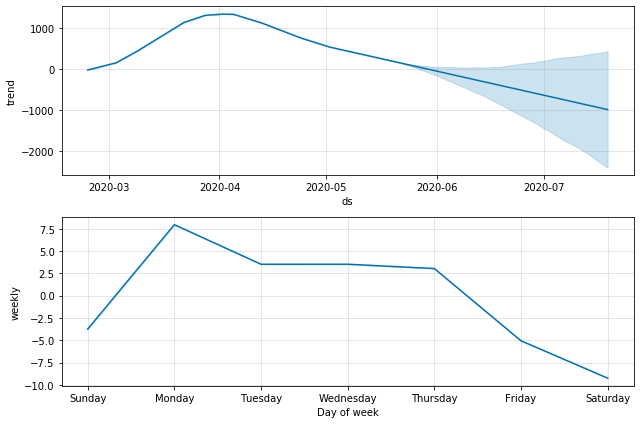

In [104]:
#fig1 = model.plot(forecast, figsize = (16, 9))
fig2 = model.plot_components(forecast)

## Previsioni con Machine Learning

### MLP Regressor

Con MLP Regressor cercheremo di predirre degli attualmente positivi, l'andamento delle terapie intensive e dei ricoverati con sintomi partendo dai dati relativi agli ospedalizzati a livello regionale, nello specifico analizzeremo la Lombardia.

Ricordiamo che anche per questi modelli sono stati utilizzati i dati all'incirca del 17 Maggio.
Per prima cosa vedremo l'andamento degli attualmente positivi.

In [113]:
#Carico la timeseries relativa agli attualmente positivi nazionali
timeseriesPCRegioniDataset = pd.read_csv("Datasets/ProtezioneCivile/dpc-covid19-ita-regioni_clean.csv")
lombardia = timeseriesPCRegioniDataset[timeseriesPCRegioniDataset["denominazione_regione"]=="Lombardia"].copy()
series = lombardia[["data", "totale_positivi"]].copy()
series.set_index("data", inplace = True)
series.head()
data = series.totale_positivi
x_1=np.arange(len(series.totale_positivi)).reshape(-1, 1)
y_1=series.totale_positivi.values

In [114]:
#Imposto le combinazioni di parametri su cui fare il tuning
#parameters = {'hidden_layer_sizes':np.arange(900,1500,100),'alpha':[0.00001,0.00005,0.0001,0.0005], 'momentum':[0.85,0.9,0.95]}
#imposto il modello con i parametri che rimarranno invariati
#model = MLPRegressor(solver="lbfgs",max_iter=50000)
#istanzio il GridSearchCV per la ricerca della combinazione di parametri migliore
#gridCV = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_squared_error')
#gridCV.fit(x_1,y_1)
#stampo i parametri scelti da gridsearchcv
#print(gridCV.best_params_)

In [115]:
# save the model to disk
#filename = 'fitted_model/model_lombardia_attualmente_positivi.sav'
#pickle.dump(gridCV, open(filename, 'wb'))

In [116]:
# load the model from disk
filename = 'fitted_model/model_lombardia_attualmente_positivi.sav'
loaded_model = pickle.load(open(filename, 'rb'))

/home/simone/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning:

Trying to unpickle estimator MLPRegressor from version 0.23.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.

/home/simone/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning:

Trying to unpickle estimator GridSearchCV from version 0.23.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.



Come per i dati italiani, anche a livello regionale abbiamo una previsione abbastanza irrealistica. Tuttavia anche in questo caso andrebbe riaddestrato il modello con i dati che saranno disponibili tra qualche settimana, per poter individuare in modo migliore l'andamento dei positivi.

In [117]:
#creo le x del test, aggiungendo 30 valori rispetto al train
test = np.arange(len(data)+30).reshape(-1, 1)
#effettuo la predizione su di essi
pred = loaded_model.predict(test)
prediction = pred.round().astype(int)
#recupero il primo index dai dati originali (che è una data), 
#gli aggiungo uno o più giorni con il ciclo sulla len di prediction, 
#ottenendo la lista delle date fino a 30 giorni dopo
week = [pd.to_datetime(data.index[0]) + timedelta(days=i) for i in range(len(prediction))]
#converto week a datetimeindex
dt_idx = pd.DatetimeIndex(week)
#creo una series con i valori in prediction e i nuovi index
predicted_count = pd.Series(prediction, dt_idx)

#aggiunge dei convertitori custom di pandas
register_matplotlib_converters()


#plotto
x_pred = predicted_count.index
y_pred = predicted_count.values
x_val = pd.DatetimeIndex(series.index)
y_val = series.totale_positivi

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_pred, y=y_pred, mode='lines', name='Previsione'))
fig.add_trace(go.Scatter(x=x_val, y=y_val, mode='lines', name='Andamento Attualmente Positivi'))
fig.show()

Vediamo ora il modello relativo alla terapia intensiva.

In [118]:
#Carico la timeseries relativa alle terapie intensive regionali
series = pd.read_csv('Datasets/ProtezioneCivile/ts_regioni_terapia.csv', index_col = 0)
series = series.T
series.head()
series.rename(columns={"denominazione_regione":"data"},inplace=True)
data = series.Lombardia
x_1=np.arange(len(series.Lombardia)).reshape(-1, 1)
y_1=series.Lombardia.values

In [119]:
#Imposto le combinazioni di parametri su cui fare il tuning
#parameters = {'hidden_layer_sizes':np.arange(500,1500,200),'alpha':[0.00001,0.00005,0.0001,0.0005], 'momentum':[0.85,0.9,0.95]}
#imposto il modello con i parametri che rimarranno invariati
#model = MLPRegressor(solver="lbfgs",max_iter=50000)
#istanzio il GridSearchCV per la ricerca della combinazione di parametri migliore
#gridCV = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_squared_error')
#gridCV.fit(x_1,y_1)
#stampo i parametri scelti da gridsearchcv
#print(gridCV.best_params_)

In [120]:
# save the model to disk
#filename = 'fitted_model/model_lombardia_terapia_intensiva.sav'
#pickle.dump(gridCV, open(filename, 'wb'))

In [121]:
# load the model from disk
filename = 'fitted_model/model_lombardia_terapia_intensiva.sav'
loaded_model = pickle.load(open(filename, 'rb'))

/home/simone/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning:

Trying to unpickle estimator MLPRegressor from version 0.21.3 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.

/home/simone/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning:

Trying to unpickle estimator GridSearchCV from version 0.21.3 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.



Vediamo il grafico relativo alla previsione dei prossimi 30 giorni. L'azzeramento delle terapie intensive è dato all'incirca al 20 di Giugno. Chiaramente anche questo modello andrebbe riaddestrato nelle prossime settimane coi dati aggiornati, in modo da catturare eventuali cambiamenti nell'andamento della curva.

In [122]:
#creo le x del test, aggiungendo 30 valori rispetto al train
test = np.arange(len(data)+30).reshape(-1, 1)
#effettuo la predizione su di essi
pred = loaded_model.predict(test)
prediction = pred.round().astype(int)
#recupero il primo index dai dati originali (che è una data), 
#gli aggiungo uno o più giorni con il ciclo sulla len di prediction, 
#ottenendo la lista delle date fino a 30 giorni dopo
week = [pd.to_datetime(data.index[0]) + timedelta(days=i) for i in range(len(prediction))]
#converto week a datetimeindex
dt_idx = pd.DatetimeIndex(week)
#creo una series con i valori in prediction e i nuovi index
predicted_count = pd.Series(prediction, dt_idx)

#aggiunge dei convertitori custom di pandas
register_matplotlib_converters()

#plotto

x_pred = predicted_count.index
y_pred = predicted_count.values
x_val = pd.DatetimeIndex(series.index)
y_val = series.Lombardia

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_pred, y=y_pred, mode='lines', name='Previsione'))
fig.add_trace(go.Scatter(x=x_val, y=y_val, mode='lines', name='Andamento Terapia Intensiva'))
fig.show()

In [123]:
#Carico la timeseries relativa agli attualmente positivi nazionali
timeseriesPCRegioniDataset = pd.read_csv("Datasets/ProtezioneCivile/dpc-covid19-ita-regioni_clean.csv")
lombardia = timeseriesPCRegioniDataset[timeseriesPCRegioniDataset["denominazione_regione"]=="Lombardia"].copy()
series = lombardia[["data", "totale_positivi","totale_ospedalizzati","terapia_intensiva","ricoverati_con_sintomi"]]
series.set_index("data", inplace = True)
series.head()
data = series.totale_positivi
x_1=np.arange(len(series.totale_positivi)).reshape(-1, 1)
y_1=series.totale_positivi.values

Ricerchiamo una correlazione tra i dati presenti nel dataset.

In [124]:
df = lombardia[["ricoverati_con_sintomi","terapia_intensiva","totale_ospedalizzati","totale_positivi"]]
fig = px.imshow(df.corr(), x=df.columns, y=df.columns)
fig.show()

Abbiamo deciso di realizzare un modello che cerchi di predirre l'andamento dei ricoverati con sintomi usando i dati relativi agli ospedalizzati.

In [125]:
new_x = series.totale_ospedalizzati[:int(len(series)*0.8)].values.reshape(-1,1)
new_x_test = series.totale_ospedalizzati[int(len(series)*0.8):].values.reshape(-1,1)
new_y = series.ricoverati_con_sintomi[:int(len(series)*0.8)].values
new_y_test = series.ricoverati_con_sintomi[int(len(series)*0.8):].values.reshape(-1,1)

In [126]:
#Imposto le combinazioni di parametri su cui fare il tuning
#parameters = {'hidden_layer_sizes':np.arange(500,1500,200),'alpha':[0.00001,0.00005,0.0001,0.0005], 'momentum':[0.85,0.9,0.95]}
#imposto il modello con i parametri che rimarranno invariati
#model = MLPRegressor(solver="lbfgs",max_iter=50000)
#istanzio il GridSearchCV per la ricerca della combinazione di parametri migliore
#gridCV = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_squared_error')
#gridCV.fit(new_x,new_y)
#stampo i parametri scelti da gridsearchcv
#print(gridCV.best_params_)

In [127]:
# save the model to disk
#filename = 'fitted_model/model_lombardia_ospedalizzati_to_ricoverati_con_sintomi.sav'
#pickle.dump(gridCV, open(filename, 'wb'))

In [128]:
# load the model from disk
filename = 'fitted_model/model_lombardia_ospedalizzati_to_ricoverati_con_sintomi.sav'
loaded_model = pickle.load(open(filename, 'rb'))

/home/simone/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning:

Trying to unpickle estimator MLPRegressor from version 0.23.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.

/home/simone/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning:

Trying to unpickle estimator GridSearchCV from version 0.23.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.



In questo caso abbiamo deciso di addestrare il modello con circa l'80% dei dati a disposizione, il grafico seguente rappresenta dunque la predizione del 20% rimanente e l'andamento effettivo dei ricoverati con sintomi.

In [129]:
#effettuo la predizione su di essi
pred = loaded_model.predict(new_x_test)
prediction = pred.round().astype(int)
#ricalcolo le date
week = [pd.to_datetime(data.index[len(new_x)]) + timedelta(days=i) for i in range(len(prediction))]
#converto week a datetimeindex
dt_idx = pd.DatetimeIndex(week)
#creo una series con i valori in prediction e i nuovi index
predicted_count = pd.Series(prediction, dt_idx)

#aggiunge dei convertitori custom di pandas
register_matplotlib_converters()


#plotto

x_pred = predicted_count.index
y_pred = predicted_count.values
x_val = pd.DatetimeIndex(series.index)
y_val = series.ricoverati_con_sintomi

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_pred, y=y_pred, mode='lines', name='Previsione'))
fig.add_trace(go.Scatter(x=x_val, y=y_val, mode='lines', name='Andamento Ricoverati con Sintomi'))
fig.show()

# Predizione Francia

In questa sezione andremo a realizzare l'analisi utilizzando, sia i modelli addestrati precedentemente con i dati italiani, sia realizzando dei nuovi modelli addestrati con i dati francesi.

Non abbiamo incluso un'analisi dei dati (stagionalità, stazionarietà, ecc.) in quanto simili ai dati italiani.

## Predizione con modelli addestrati sui dati italiani

Andremo ora a predirre l'andamento della terapia intensiva francese utilizzando i modelli addestrati precedentemente.

### Arima

In [130]:
series = pd.read_csv('Datasets/Francia/france_clean.csv', index_col = 0)
#series = series.T
series.reset_index(inplace=True)
series = series[series["maille_nom"]=="France"]
series = series[["date", "reanimation"]]
series.reset_index(inplace=True)
series = series.drop("index", axis=1)
series.set_index('date', inplace=True)
series = series.truncate(before="2020-02-24")

In [131]:
with open("fitted_model/arima_model.pkl", 'rb') as file:
    pickle_model = pickle.load(file)

In [132]:
series_scaled = scale(series)

In [133]:
forecast = pickle_model.predict(start = len(series), end = (len(series)-1) + 60, typ = 'levels').rename('Forecast')

forecast = forecast.to_frame(name="reanimation")
forecast.reset_index(inplace=True)
forecast.rename(columns = {'index':'date', 'reanimation':'reanimation'}, inplace = True)
forecast.set_index('date', inplace=True)

In [134]:
forecast = reverse_scale(forecast)

Vediamo come vi sia un distacco tra i dati reali e i dati predetti. L'azzeremento risulta essere intorno al 17 di Giugno.

In [135]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=series.index, y=series["reanimation"], mode='lines', name='reanimation'))
fig.add_trace(go.Scatter(x=forecast.index, y=forecast["reanimation"], mode='lines', name='Prediction'))
fig.add_shape(type="line",x0=series.index[0],y0=0,x1=forecast.index[-1],y1=0)
fig.show()

In [136]:
forecast = pickle_model.predict(start = 0 , end = (len(series)-1), typ = 'levels').rename('Forecast')

forecast = forecast.to_frame(name="reanimation")
forecast.reset_index(inplace=True)
forecast.rename(columns = {'index':'date', 'reanimation':'reanimation'}, inplace = True)
forecast.set_index('date', inplace=True)

In [137]:
forecast = reverse_scale(forecast)

In [138]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=series.index, y=series["reanimation"], mode='lines', name='reanimation'))
fig.add_trace(go.Scatter(x=forecast.index, y=forecast["reanimation"], mode='lines', name='Prediction'))
fig.add_shape(type="line",x0=series.index[0],y0=0,x1=forecast.index[-1],y1=0)
fig.show()

### MLPRegressor

Proveremo ora a realizzare un modello sui dati italiani per predirre l'andamento della terapia intensiva, partendo dal numero dei positivi e dal numero degli ospedalizzati. Andremo poi a effettuare una predizione su questo modello utilizzando i dati francesi.

Il modello è stato addestrato sulla totalità dei dati a disposizione.

Anche in questo caso ricordiamo che i dati utilizzati per l'addestramento del modello corrispondono all'incirca al 17 di Maggio.

In [139]:
#Carico la timeseries relativa agli attualmente positivi nazionali
timeseriesPCNazionaleDataset = pd.read_csv("Datasets/ProtezioneCivile/dpc-covid19-ita-andamento-nazionale_clean.csv")
series = timeseriesPCNazionaleDataset[["data", "totale_positivi","totale_ospedalizzati","terapia_intensiva"]].copy()
series.set_index("data", inplace = True)
series.head()
data = series.totale_positivi
x_1=series[["totale_positivi","totale_ospedalizzati"]]
y_1=series.terapia_intensiva.values

In [140]:
#Imposto le combinazioni di parametri su cui fare il tuning
#parameters = {'hidden_layer_sizes':np.arange(500,1500,200),'alpha':[0.00001,0.00005,0.0001,0.0005], 'momentum':[0.85,0.9,0.95]}
#imposto il modello con i parametri che rimarranno invariati
#model = MLPRegressor(solver="lbfgs",max_iter=50000)
#istanzio il GridSearchCV per la ricerca della combinazione di parametri migliore
#gridCV = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_squared_error',n_jobs=-1)
#gridCV.fit(x_1[:int(len(x_1)*0.8)],y_1[:int(len(x_1)*0.8)])
#stampo i parametri scelti da gridsearchcv
#print(gridCV.best_params_)

In [141]:
# save the model to disk
#filename = 'model_italia_osp_e_pos_a_ti.sav'
#pickle.dump(gridCV, open(filename, 'wb'))

In [142]:
# load the model from disk
filename = 'fitted_model/model_italia_osp_e_pos_a_ti.sav'
loaded_model = pickle.load(open(filename, 'rb'))

/home/simone/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning:

Trying to unpickle estimator MLPRegressor from version 0.23.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.

/home/simone/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning:

Trying to unpickle estimator GridSearchCV from version 0.23.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.



Dal grafico vediamo come la predizione si discosti leggermente dai dati reali.

In [143]:
#effettuo la predizione su di essi
pred = loaded_model.predict(x_1)

prediction = pred.round().astype(int)
#recupero il primo index dai dati originali (che è una data), 
#gli aggiungo uno o più giorni con il ciclo sulla len di prediction, 
#ottenendo la lista delle date fino a 30 giorni dopo
week = [pd.to_datetime(data.index[0]) + timedelta(days=i) for i in range(len(prediction))]
#converto week a datetimeindex
dt_idx = pd.DatetimeIndex(week)
#creo una series con i valori in prediction e i nuovi index
predicted_count = pd.Series(prediction, dt_idx)

#aggiunge dei convertitori custom di pandas
register_matplotlib_converters()


#plotto
x_pred = predicted_count.index
y_pred = predicted_count.values
x_val = pd.DatetimeIndex(series.index)
y_val = series.terapia_intensiva

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_pred, y=y_pred, mode='lines', name='Previsione'))
fig.add_trace(go.Scatter(x=x_val, y=y_val, mode='lines', name='Andamento Terapia Intensiva'))
fig.show()

Andiamo ora a caricare i dati relativi alla Francia e a sistemare relative colonne. Non essendo disponibile il dato relativo agli attualmente positivi (totale_positivi) andremo a calcolarla.

In [144]:
#Carico la timeseries relativa agli attualmente positivi nazionali
francia = pd.read_csv("Datasets/Francia/france_clean.csv")
francia = francia[francia["maille_nom"]=="France"]
francia.rename(columns={"reanimation":"terapia_intensiva","hospitalises":"totale_ospedalizzati"},inplace=True)
francia["totale_positivi"] = francia["cas_confirmes"]-francia["deces"]-francia["gueris"]-francia["depistes"]

francia.set_index("date", inplace = True)

francia = francia [["totale_positivi","totale_ospedalizzati","terapia_intensiva"]]

francia.head()

,totale_positivi,totale_ospedalizzati,terapia_intensiva
date,,,
2020-01-24,3.0,3.0,0.0
2020-01-25,3.0,0.0,0.0
2020-01-26,3.0,0.0,0.0
2020-01-27,3.0,3.0,0.0
2020-01-28,4.0,4.0,1.0


In [145]:
x_2=francia[["totale_positivi","totale_ospedalizzati"]]
y_2=francia.terapia_intensiva.values

Effettuiamo ora una predizione sui dati francesi, vediamo come il modello non riesca ad individuare il picco dei 7000 in terapia intensiva, ma nei dati degli ultimi giorni sembrerebbe rispecchiare maggiormente la realtà dei dati.

In [146]:
#effettuo la predizione su di essi
pred = loaded_model.predict(x_2)
prediction = pred.round().astype(int)


#plotto

x_pred = pd.DatetimeIndex(francia.index)
y_pred = prediction
x_val = pd.DatetimeIndex(francia.index)
y_val = francia.terapia_intensiva

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_pred, y=y_pred, mode='lines', name='Previsione'))
fig.add_trace(go.Scatter(x=x_val, y=y_val, mode='lines', name='Andamento Terapia Intensiva'))
fig.show()

## Nuovo modello addestrato con dati francesi

In questa sezione andremo ad addestrare i modelli direttamente con i dati francesi.

In [147]:
series = pd.read_csv('Datasets/Francia/france_clean.csv', index_col = 0)
#series = series.T
series.reset_index(inplace=True)
series = series[series["maille_nom"]=="France"]
series = series[["date", "reanimation"]]
series.reset_index(inplace=True)
series = series.drop("index", axis=1)
series.set_index('date', inplace=True)
series = series.truncate(before="2020-02-24")

In [148]:
series_arima = series.copy()
print(series_arima)

            reanimation
date                   
2020-02-24          0.0
2020-02-25          0.0
2020-02-26          0.0
2020-02-27          2.0
2020-02-28          0.0
...                 ...
2020-05-16       2132.0
2020-05-17       2087.0
2020-05-18       1998.0
2020-05-19       1894.0
2020-05-20       1794.0

[87 rows x 1 columns]


In [149]:
stepwise_fit = auto_arima(series_arima['reanimation'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',
                          suppress_warnings = True,
                          stepwise = True)
stepwise_fit.summary() 

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=960.153, BIC=971.673, Time=1.810 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=1046.357, BIC=1050.966, Time=0.018 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=975.433, BIC=984.649, Time=0.970 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=986.793, BIC=996.010, Time=0.952 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=1044.578, BIC=1046.882, Time=0.024 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=996.268, BIC=1005.484, Time=0.185 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=962.972, BIC=976.796, Time=2.629 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   87
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -471.805
Date:                              Fri, 22 May 2020   AIC                            957.609
Time:                                      11:10:31   BIC                            973.738
Sample:                                           0   HQIC                           964.043
                                               - 87                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9753      4.623     -0.427      0.669     -11.037       7.086
ar.L1          0.2301      0.130      1.770      0.077      -0.025       0.485
ar.L2          0.6929      0.083      8.327      0.000       0.530       0.856
ma.L1          0.4301      1.774      0.243      0.808      -3.046       3.906
ma.L2         -0.5660      0.958     -0.591      0.555      -2.444       1.312
ma.S.L12      -0.9930      9.424     -0.105      0.916     -19.463      17.477
sigma2      1.407e+04   1.25e+05      0.112      0.911   -2.32e+05     2.6e+05
===================================================================================
Ljung-Box (Q):                       31.71   Jarque-Bera (JB):                 9.30
Prob(Q):                              0.82   Prob(JB):                         0.01
Heteroskedasticity (H):               0.26   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [150]:
train = series_arima.iloc[:int(len(series)*0.70)] 
test = series_arima.iloc[int(len(series)*0.70):]

In [151]:
model = SARIMAX(train['reanimation'], order = (2, 1, 2), seasonal_order =(0, 1, 1, 12)) 

result = model.fit() 
result.summary() 

/home/simone/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/simone/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/simone/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/home/simone/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          reanimation   No. Observations:                   60
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -308.898
Date:                              Fri, 22 May 2020   AIC                            629.795
Time:                                      11:10:33   BIC                            640.896
Sample:                                  02-24-2020   HQIC                           633.973
                                       - 04-23-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2376      0.262      0.906      0.365      -0.276       0.751
ar.L2          0.7217      0.166      4.360      0.000       0.397       1.046
ma.L1          0.4275      6.713      0.064      0.949     -12.730      13.585
ma.L2         -0.5694      3.783     -0.150      0.880      -7.985       6.846
ma.S.L12      -0.9971     56.557     -0.018      0.986    -111.846     109.852
sigma2      1.895e+04   1.01e+06      0.019      0.985   -1.97e+06    2.01e+06
===================================================================================
Ljung-Box (Q):                       25.83   Jarque-Bera (JB):                 3.59
Prob(Q):                              0.96   Prob(JB):                         0.17
Heteroskedasticity (H):               0.58   Skew:                             0.45
Prob(H) (two-sided):                  0.28   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Andiamo ora a effettuare la validazione sui dati di test (circa il 30%). Vediamo come la predizione del modello non riesca ad apprendere totalmente l'andamento dei dati reali.

In [152]:
start = len(train) 
end = len(train) + len(test) - 1

predictions = result.predict(start, end, typ = 'levels').rename("Predictions") 

predictions = predictions.to_frame(name="reanimation")
predictions.reset_index(inplace=True)
predictions.rename(columns = {'index':'date', 'reanimation':'reanimation'}, inplace = True)
predictions.set_index('date', inplace=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index, y=test["reanimation"], mode='lines', name='reanimation'))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions["reanimation"], mode='lines', name='Prediction'))
fig.show()

In [153]:
model = SARIMAX(series_arima['reanimation'], order = (1, 1, 1), seasonal_order =(0, 1, 1, 12), freq="D") 
result = model.fit()

/home/simone/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Vediamo come Arima dia l'azzeramento delle terapie intensive intorno al 5 di Giugno. Tuttavia per quanto detto precedentemente, la seguente predizione non risulterà realistica.

In [154]:
forecast = result.predict(start = len(series), end = (len(series)-1) + 60, typ = 'levels').rename('Forecast')

forecast = forecast.to_frame(name="reanimation")
forecast.reset_index(inplace=True)
forecast.rename(columns = {'index':'date', 'reanimation':'reanimation'}, inplace = True)
forecast.set_index('date', inplace=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=series_arima.index, y=series_arima["reanimation"], mode='lines', name='reanimation'))
fig.add_trace(go.Scatter(x=forecast.index, y=forecast["reanimation"], mode='lines', name='Prediction'))
fig.add_shape(type="line",x0=series_arima.index[0],y0=0,x1=forecast.index[-1],y1=0)
fig.show()

### MLPRegressor

Proviamo infine ad addestrare il modello visto precedentemente direttamente con i dati francesi.

In [155]:
#Carico la timeseries relativa agli attualmente positivi nazionali
francia = pd.read_csv("Datasets/Francia/france_clean.csv")
francia = francia[francia["maille_nom"]=="France"]
francia.rename(columns={"reanimation":"terapia_intensiva","hospitalises":"totale_ospedalizzati"},inplace=True)
francia["totale_positivi"] = francia["cas_confirmes"]-francia["deces"]-francia["gueris"]-francia["depistes"]

francia.set_index("date", inplace = True)

francia = francia [["totale_positivi","totale_ospedalizzati","terapia_intensiva"]]

francia.head()

,totale_positivi,totale_ospedalizzati,terapia_intensiva
date,,,
2020-01-24,3.0,3.0,0.0
2020-01-25,3.0,0.0,0.0
2020-01-26,3.0,0.0,0.0
2020-01-27,3.0,3.0,0.0
2020-01-28,4.0,4.0,1.0


In [156]:
x_2=francia[["totale_positivi","totale_ospedalizzati"]]
y_2=francia.terapia_intensiva.values

In [157]:
#Imposto le combinazioni di parametri su cui fare il tuning
#parameters = {'hidden_layer_sizes':np.arange(500,1500,200),'alpha':[0.00001,0.00005,0.0001,0.0005], 'momentum':[0.85,0.9,0.95]}
#imposto il modello con i parametri che rimarranno invariati
#model = MLPRegressor(solver="lbfgs",max_iter=50000)
#istanzio il GridSearchCV per la ricerca della combinazione di parametri migliore
#gridCV = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_squared_error',n_jobs=-1)
#gridCV.fit(x_2[:int(len(x_2)*0.9)],y_2[:int(len(x_2)*0.9)])
#stampo i parametri scelti da gridsearchcv
#print(gridCV.best_params_)

In [158]:
# save the model to disk
#filename = 'model_francia_osp_e_pos_a_ti.sav'
#pickle.dump(gridCV, open(filename, 'wb'))

In [159]:
# load the model from disk
filename = 'fitted_model/model_francia_osp_e_pos_a_ti.sav'
loaded_model = pickle.load(open(filename, 'rb'))

/home/simone/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning:

Trying to unpickle estimator MLPRegressor from version 0.23.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.

/home/simone/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning:

Trying to unpickle estimator GridSearchCV from version 0.23.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.



Possiamo notare che, come per il modello italiano basato sulle stesse informazioni, anche questo si discosta dall'andamento reale. 

In [160]:
#effettuo la predizione su di essi
pred = loaded_model.predict(x_2)
prediction = pred.round().astype(int)


#plotto

x_pred = pd.DatetimeIndex(francia.index)
y_pred = prediction
x_val = pd.DatetimeIndex(francia.index)
y_val = francia.terapia_intensiva

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_pred, y=y_pred, mode='lines', name='Previsione'))
fig.add_trace(go.Scatter(x=x_val, y=y_val, mode='lines', name='Andamento Terapia Intensiva'))
fig.show()

## Conclusioni sui modelli

È stato possibile utilizzare diverse tipologie di modelli per provare a rispondere alla domanda posta in partenza.
La seguente sezione si pone lo scopo di commentare i risultati ottenuti modello per modello per tutte le analisi effettuate, in quanto simili tra loro. Inoltre, è stato pensato di utilizzare alcuni di questi modelli addestrati usando i dati italiani, Arima e MLP Regressor, ed applicarli ai dati francesi, così da osservarne il comportamento su nuovi dati.

### Autoregression
Osservando i dati relativi al periodo successivo ai picchi di Aprile, è possibile notare una discesa lineare.
Di conseguenza, vi è la possibilità di applicare l’Autoregression che, come precedentemente detto, si basa su una equazione di regressione lineare. Questo permette quindi di ottenere un risultato soddisfacente.

Infatti, per quanto riguarda l'analisi nazionale, il risultato ottenuto è conforme al dato reale, distanziandosi di una sola unità al 21 Maggio. L’analisi a livello lombardo, invece, si è discostata di 6 unità.

### Moving Average
La Moving Average si comporta in maniera simile all’Autoregression con i dati lineari. Questo poichè utilizza una funzione lineare dell'errore residuo dato da una media dei precedenti valori. Di conseguenza, anche in questo caso, abbiamo ottenuto un risultato soddisfacente.

Infatti, per quanto riguarda l'analisi nazionale, il risultato è meno preciso rispetto al modello precedente con un discostamento maggiore rispetto al dato reale. A livello lombardo, invece, la previsione è risultata accurata.

### Arima (Autoregressive Integrated Moving Average) 
Arima è un modello basato sulla combinazione di Autoregression e Moving Average, di conseguenza è adatto a dati che peccano di stagionalità ma che seguono un andamento lineare.

Arima è stato utilizzato in tutte e tre le analisi effettuate. Inoltre, è stato sperimentato il modello ricavato dal dataset nazionale italiano sui dati francesi, ottenendo però un pessimo risultato. Questo poiché i dati delle due nazioni sono troppo differenti tra loro.

Per quanto riguarda i singoli modelli addestrati e le relative previsioni abbiamo ottenuto i seguenti risultati:
- Italia: nel caso italiano la predizione è risultata coerente con il dato reale;
- Lombardia: nel caso lombardo la predizione si è discostata di 12 dalla reltà;
- Francia: nel caso francese la predizione si è discostata di circa 80 dalla reltà.

Tutti i modelli si discostano dalla realtà con l'avanzare dei giorni, ciò è probabilmente dovuto alla variazione della discesa dei dati reali rispetto ai dati su cui il modello ha effettuato la previsione.

### Prophet
Prophet è un modello di tipo additivo che lavora meglio con time series che hanno una forte stagionalità e diversi "stagioni" di dati. Nonostante il fatto di disporre di dataset privi di stagionalità, è stato comunque deciso di effettuare una analisi tramite Prohpet. 

I risultati ottenuti confermano questa affermazione concludendo predizioni notevolmente discostate dalla realtà sia nel caso italiano sia in quello lombardo.

### MLP Regressor
Il Multi-layer perceptron regressor è una rete neurale che viene addestrata iterativamente. In ogni fase vengono calcolate le derivate parziali relative alla funzione di costo (loss function) rispetto ai parametri del modello, in modo da aggiornare quest'ultimi.

I parametri di questo modello sono stati ottimizzati utilizzando GridSearchCV.

È stato deciso di sperimentare maggiormente questo modello, effettuando diversi tipi di predizioni.

#### Italia
Per quanto riguarda la situazione italiana è stato deciso di provare a predirre l'andamento delle terapie intensive. Il primo dato predetto dal modello si discosta molto da quello reale, tuttavia al giorno 28 di Maggio è stata data una predizione quasi corrispondente al dato reale. È possibile quindi affermare che il modello abbia imparato correttamente l'andamento della curva.

Per quanto riguarda il valore degli attualmente positivi, è possibile notare da subito un andamento irrealistico, derivante dal fatto che l'azzeramento di questi ultimi avvenga prima dell'azzeramento delle terapie intensive precedentemente predetto. Questo può essere stato causato dalla limitatezza dei dati e dalla discesa troppo ripida della curva nei dati disponibili. Infatti, nei primi giorni è stato possibile predirre un valore molto simile alla realtà, mentre al 28 di Maggio è risultato differente di circa 2000 unità.

Infine, è stato deciso di determinare l'andamento degli ospedalizzati partendo dai positivi. Dunque, per poter predire il futuro servirà fornire in ingresso i valori degli attualmente positivi predetti precedentemente. Purtroppo, il modello non è riuscito ad apprendere correttamente l'andamento della curva; si è verificato, infatti, uno slittamento del dato predetto di circa 10 giorni.

#### Lombardia
Per quanto riguarda la situazione lombarda, è stato deciso di provare a predirre l'andamento delle terapie intensive. Il primo dato predetto dal modello si discosta molto da quello reale, ciò avviene anche nei giorni successivi, rimanendo comunque costante nella sua discesa. Questo probabilmente è dovuto al notevole rallentamento nella discesa del dato reale, non prevedibile dal modello con i dati disponibili al momento dell'addestramento.

Per quanto riguarda gli attualmente positivi, anche in questo caso il modello non è riuscito ad apprendere correttamente l'andamento della curva. Si può infatti notare un discostamento dalla realtà di circa 2000 unità, probabilmente è dovuto al fatto che i dati reali abbiano un andamento contenente dei picchi.

Infine, è stato deciso di provare a predirre l'andamento dei ricoverati con sintomi utilizzando i dati relativi agli ospedalizzati. In questo caso non è stato possibile predirre il futuro in quanto è risultato difficile addestrare il modello relativo agli ospedalizzati, poichè la predizione risultava essere una linea in costante ascesa. Tuttavia, è stato deciso di addestrare il modello con l'80% dei dati e di effettuare un test di validazione con il restante 20%. La predizione del modello è risultata abbastanza accurata seguendo correttamente l'andamento dei dati reali, anche se con un discostamento di circa 200 unità.

#### Francia
Innanzitutto è stato creato un nuovo modello capace di predirre l'andamento delle terapie intensive, partendo dal valore degli attualmente positivi e degli attualmente ospedalizzati, addestrandolo con i dati italiani. A questo modello, sono stati poi forniti i dati francesi in input e gli è stato chiesto di predirre i valori della terapia intensiva francese. È stato osservato però come il modello non sia stato in grado di individuare il picco avvenuto a circa metà Aprile, tuttavia sembrerebbe percepire in modo corretto i dati degli ultimi giorni.

Infine, è stato provato il riaddestramento del modello utilizzando il 90% dei dati francesi ed effettuando il test sul rimanente 10%. In questo caso, il modello ha imparato ad individuare il picco di metà Aprile, tuttavia nei dati di test risulta discostarsi dalla realtà di circa 800 unità. Ciò è dovuto al fatto che, dovendolo addestrare direttamente con i dati francesi, si siano ridotti i valori a disposizione per l'addestramento.

### Conclusioni
È stato possibile osservare come i modelli statistici riescano ad ottenere ottimi risultati nella predizione del giorno successivo, ciononostante peccano nelle previsioni a lungo termine.

Per quanto riguarda i modelli di machine learning realizzati con MLP Regressor, sono stati ottenuti risultati differenti. In alcuni casi sembrerebbe che la previsione corrisponda alla realtà, in altri si discosta già dai primi valori predetti. Ciò è dovuto sicuramente al fatto che questo tipo di modello richieda comunque una grande quantità di dati per poter operare al meglio.